In [206]:
import pandas as pd
import numpy as np
from time import time
from sklearn import preprocessing
import statsmodels.api as sm
from scipy.stats import f
from scipy.stats import multivariate_normal
from scipy.signal import find_peaks
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.holtwinters import Holt, SimpleExpSmoothing
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

### Data processing

Extract data from Johns Hopkins (aggregated data from WHO daily reports)

In [210]:
url1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
cases = pd.read_csv(url1)
deaths = pd.read_csv(url2)

Delete longitude and latitude fields



In [211]:
del cases['Lat']
del cases['Long']
del deaths['Lat']
del deaths['Long']

Group by country

In [212]:
cases = cases.groupby("Country/Region", as_index=False).sum()
deaths = deaths.groupby("Country/Region", as_index=False).sum()

In [213]:
new_cases = pd.DataFrame(cases["Country/Region"])
for i in range(2, len(cases.columns)):     #check index with df form
  new_cases[cases.columns[i]] = cases[cases.columns[i]] - cases[cases.columns[i-1]]
new_deaths = pd.DataFrame(deaths["Country/Region"])
for i in range(2, len(deaths.columns)):     #check index with df form
  new_deaths[deaths.columns[i]] = deaths[deaths.columns[i]] - deaths[deaths.columns[i-1]]

Set time lag between diagnostics and death

In [214]:
lag = 8

In [215]:
deaths_shift = new_deaths.iloc[:,1:].shift(-lag, axis=1).iloc[:,:-lag]
deaths_shift['Country/Region'] = new_deaths['Country/Region']

In [216]:
new_cases = new_cases.set_index("Country/Region")
new_deaths = new_deaths.set_index("Country/Region")
deaths_shift = deaths_shift.set_index("Country/Region")

In [217]:
death_rate = deaths_shift.div(new_cases, fill_value=np.nan)

In [218]:
death_rate = death_rate.fillna(0)

In [219]:
death_rate = death_rate.replace(np.inf, 1)

In [220]:
death_rate = death_rate.clip(0, 1)

In [221]:
rate_lst = death_rate.values.tolist()

In [222]:
labels = death_rate.index.to_list()

Assuming polynomial degree 4, create timestamps

In [223]:
p = 4
ts_size = len(cases_lst[0])
x_range = np.array(range(ts_size))
x = np.array([x_range**0, x_range, x_range**2, x_range**3, x_range**4, x_range**5, x_range**6, x_range**7, x_range**8, x_range**9, x_range**10, x_range**11, x_range**12, x_range**13]).T

In [224]:
smooth_lst = []
for i in range(len(rate_lst)):
    holt = SimpleExpSmoothing(rate_lst[i])
    fit = holt.fit(smoothing_level=0.2,optimized=False)
    smooth_lst.append(fit.fittedvalues)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:924: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:930: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)


In [225]:
smooth_lst = np.array(smooth_lst)

No handles with labels found to put in legend.


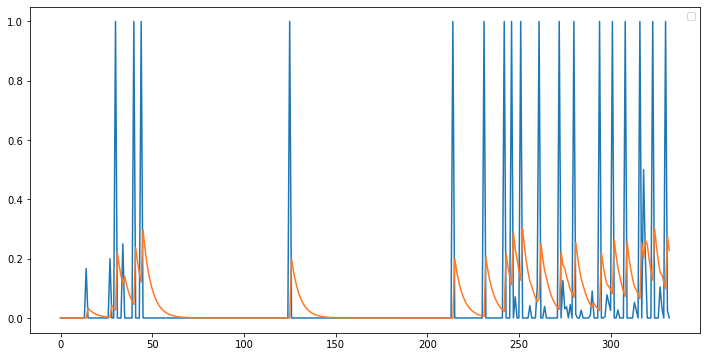

In [226]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(rate_lst[64])
ax.plot(smooth_lst[64], color='#ff7823')
plt.legend();

### Regression Mixtures

In [227]:
k = 6

In [228]:
class Regression_Mixtures_Model:
    def __init__(self, k, n, p, ts_size):
        self.k = k
        self.n = n
        self.p = p
        self.tslen = ts_size
        self.ll_old = -np.inf
        self.ll_new = -100000000000000000000000000
        self.ll_stat = []
        self.clust_stat = []

    def indicator_max(self, array):
        max_idx = max(list(zip(array, range(self.k))))
        return [0]*(max_idx[1])+[1]+[0]*(self.k-max_idx[1]-1)
    
    def init_EM(self, ypr_lst, x):
        self.tau_lst = []
        for i in range(self.n):
            t = np.random.randint(1, 10, self.k)
            self.tau_lst.append(t/sum(t))
        self.tau_lst = np.array(self.tau_lst)
        self.x_new = np.tile(x.T, self.n).T
        self.y_new = np.concatenate(ypr_lst)
        self.clust_stat.append(sum(np.array([self.indicator_max(self.tau_lst[i]) for i in range(self.n)])))
   
    def Expectation(self, ypr_lst, x, rate):
        self.tau_lst = []
        self.ll_old = self.ll_new
        ll_lst = []
        denom = np.sqrt(2*np.pi*self.cov_lst)
        #denom = denom/sum(denom)
        for i in range(self.n):
            tmp = -sum((([ypr_lst[i]]*self.k - np.dot(x, np.transpose(self.par_lst)).T)**2).T)
            num = np.exp(tmp/(2*self.cov_lst**0.6))   #here the covariance breaks
            prbs = rm.pi*num/denom
            #prbs = self.pi*[multivariate_normal(np.dot(x,self.par_lst[j]), self.cov_lst[j]).pdf(ypr_lst[i]) for j in range(self.k)]
            self.tau_lst.append(prbs/sum(prbs))
            ll_lst.append(np.log(prbs))
        ll_lst = np.array(ll_lst)
        self.tau_lst = np.array(self.tau_lst)
        self.ll_new = sum(sum(ll_lst*self.tau_lst))
        self.ll_stat.append(self.ll_new)
        self.clust_stat.append(sum(np.array([self.indicator_max(self.tau_lst[i]) for i in range(self.n)])))

    def Maximization(self, ypr_lst, x):
        self.pi = 1/self.n*sum(self.tau_lst)
        #ttt = [np.ravel([np.tile(self.tau_lst[j][i], self.tslen) for j in range(self.n)]) for i in range(self.k)]
        #off = 0
        #Hk = [sps.dia_matrix((ttt[i], off), shape=(len(ttt[i]), len(ttt[i]))) for i in range(self.k)]
        pt1_new = [np.linalg.inv(sum([self.tau_lst[j][i]*np.dot(x.T, x) for j in range(self.n)])) for i in range(self.k)]
        self.par_lst = [np.dot(pt1_new[i], sum([self.tau_lst[j][i]*np.dot(x.T, ypr_lst[j]) for j in range(self.n)])) for i in range(self.k)]
        self.cov_lst = [sum([sum(self.tau_lst[j][i]*(ypr_lst[j] - np.dot(x, self.par_lst[i]))**2) for j in range(self.n)]) for i in range(self.k)]/sum(self.tau_lst)
        self.avg_disp = np.mean(self.cov_lst)
        self.cov_lst = np.array(self.cov_lst)
    
    def EM(self, ypr_lst, x, eps=0.01):
        self.init_EM(ypr_lst, x)
        rate = 1
        self.rate_stat = [1]
        for i in range(100):#while self.ll_new - self.ll_old > eps:
            self.Maximization(ypr_lst, x)
            #break
            self.Expectation(ypr_lst, x, rate)
            #self.clust_stat.append(sum(np.array([self.indicator_max(self.tau_lst[i]) for i in range(self.n)])))
            #rate += (self.ll_old - self.ll_new)/self.ll_old
            #self.rate_stat.append(rate)
        self.output = [self.indicator_max(self.tau_lst[i]) for i in range(self.n)]


In [229]:
rm = Regression_Mixtures_Model(k, len(rate_lst), p, len(x))
rm.EM(np.array(rate_lst), x, eps=0.001)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


In [ ]:
rm.clust_stat[-1]

array([191,   0,   0,   0,   0,   0])

In [ ]:
reg_lin = np.dot(x, np.transpose(rm.par_lst)).T

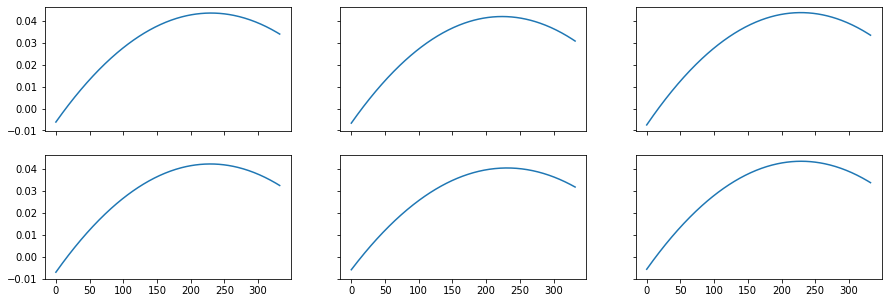

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(15,5), sharex=True, sharey=True)
for i in range(6):
    axs[i//3, np.mod(i,3)].plot(reg_lin[i])

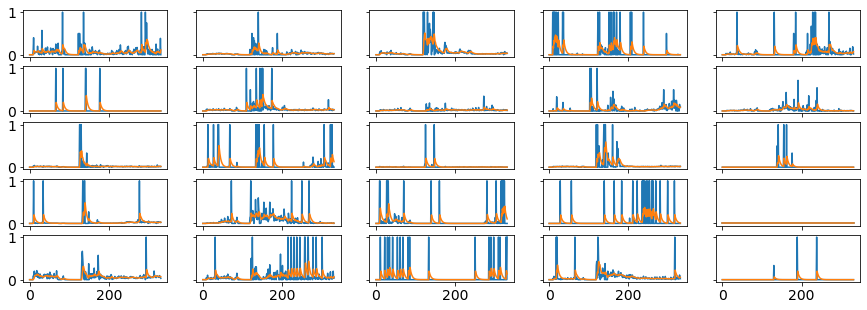

In [ ]:
fig, axs = plt.subplots(5,5, figsize=(15,5), sharex=True, sharey=True)
for i in range(25):
    axs[i//5, np.mod(i,5)].plot(np.array(rate_lst)[i])
    axs[i//5, np.mod(i,5)].plot(np.array(smooth_lst)[i])
    axs[i//5, np.mod(i,5)].tick_params(axis="x", labelsize=14)
    axs[i//5, np.mod(i,5)].tick_params(axis="y", labelsize=14)

In [14]:
cases_lst = new_cases.values.tolist()
cases_labels = new_cases.index.tolist()

In [15]:
deaths_lst = new_deaths.values.tolist()
deaths_labels = new_deaths.index.tolist()

In [53]:
ind = []
for i in range(len(cases_labels)):
    if cases_lst[i].count(0)/len(cases_lst[i]) < 0.4 and deaths_lst[i].count(0)/len(deaths_lst[i]) < 0.6:
        ind.append(i)

In [54]:
len(ind)

88

In [68]:
sel_labels = np.array(cases_labels)[ind]

In [57]:
cases_lst = np.array(cases_lst)[ind]
deaths_lst = np.array(deaths_lst)[ind]

In [58]:
smooth_cases = []
for i in range(len(cases_lst)):
    holt = Holt(cases_lst[i])
    fit = holt.fit(smoothing_level=0.2, smoothing_slope=0.2,optimized=False)
    ses = SimpleExpSmoothing(fit.fittedvalues)
    fit1 = ses.fit(smoothing_level=0.2, optimized=False)
    smooth_cases.append(fit1.fittedvalues)

In [59]:
smooth_cases = np.array(smooth_cases)

In [60]:
smooth_deaths = []
for i in range(len(deaths_lst)):
    holt = Holt(deaths_lst[i])
    fit = holt.fit(smoothing_level=0.2, smoothing_slope=0.2,optimized=False)
    ses = SimpleExpSmoothing(fit.fittedvalues)
    fit1 = ses.fit(smoothing_level=0.2, optimized=False)
    smooth_deaths.append(fit1.fittedvalues)

In [61]:
smooth_deaths = np.array(smooth_deaths)

In [99]:
ypr_lst = []
for i in range(len(deaths_lst)):
    y = cases_lst[i]
    y_mean = np.mean(y)
    lr_fin = sm.OLS(y, x[:,:2]).fit()
    x1a = x[:,:2]
    for j in range(2, 8):
        lr0 = lr_fin
        x0 = x1a
        y_pr0 = lr0.predict(x0)
        ssr0 = sum((y_pr0 - y_mean)**2)
        x1a = x[:, :j+1]
        lr1 = sm.OLS(y, x1a).fit()
        y_pr1 = lr1.predict(x1a)
        ssr1 = sum((y_pr1 - y_mean)**2)
        ssr_new = ssr1 - ssr0
        mse1 = sum((y - y_pr1)**2)/(len(y) + j - 2)
        if ssr_new/mse1 <= f.ppf(0.05, 1, (len(y) + j - 2)):
            y_pr = y_pr0
            x_fin = x0
            break
        y_pr = y_pr1
        x_fin = x1a
        lr_fin = lr1  
    ypr_lst.append(y_pr)

In [100]:
ypr_lst1 = []
for i in range(len(deaths_lst)):
    y = deaths_lst[i]
    y_mean = np.mean(y)
    lr_fin = sm.OLS(y, x[:,:2]).fit()
    x1a = x[:,:2]
    for j in range(2, 8):
        lr0 = lr_fin
        x0 = x1a
        y_pr0 = lr0.predict(x0)
        ssr0 = sum((y_pr0 - y_mean)**2)
        x1a = x[:, :j+1]
        lr1 = sm.OLS(y, x1a).fit()
        y_pr1 = lr1.predict(x1a)
        ssr1 = sum((y_pr1 - y_mean)**2)
        ssr_new = ssr1 - ssr0
        mse1 = sum((y - y_pr1)**2)/(len(y) + j - 2)
        if ssr_new/mse1 <= f.ppf(0.05, 1, (len(y) + j - 2)):
            y_pr = y_pr0
            x_fin = x0
            break
        y_pr = y_pr1
        x_fin = x1a
        lr_fin = lr1  
    ypr_lst1.append(y_pr) 

In [119]:
test_cases = (smooth_cases + 2*np.array(ypr_lst))/3
test_deaths = (smooth_deaths + 2*np.array(ypr_lst1))/3

In [195]:
peaks = []
peak_vals = []
peak_rates = []
for i in range(len(smooth_cases)):
    tmp_peaks, _ = find_peaks(smooth_cases[i], height=300, distance=100)
    peaks.append(tmp_peaks)
    peak_vals.append(np.array(smooth_cases[i])[tmp_peaks])
    peak_rates.append(np.array(smooth_deaths[i])[tmp_peaks]/np.array(smooth_cases[i])[tmp_peaks])

In [186]:
def plot_lines(n):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].plot(cases_lst[n])
    ax[0].plot(smooth_cases[n], color='#ff7823')
    #ax[0].plot(ypr_lst[n], color='#122823')
    #ax[0].plot(test_cases[n], color='#991219')
    ax[0].plot(peaks[n], peak_vals[n], "x", color='#991219')
    ax[1].plot(deaths_lst[n])
    ax[1].plot(smooth_deaths[n], color='#ff7823')
    #ax[1].plot(ypr_lst1[n], color='#122823')
    #ax[1].plot(test_deaths[n], color='#991219')
    fig.suptitle(sel_labels[n], fontsize=16)

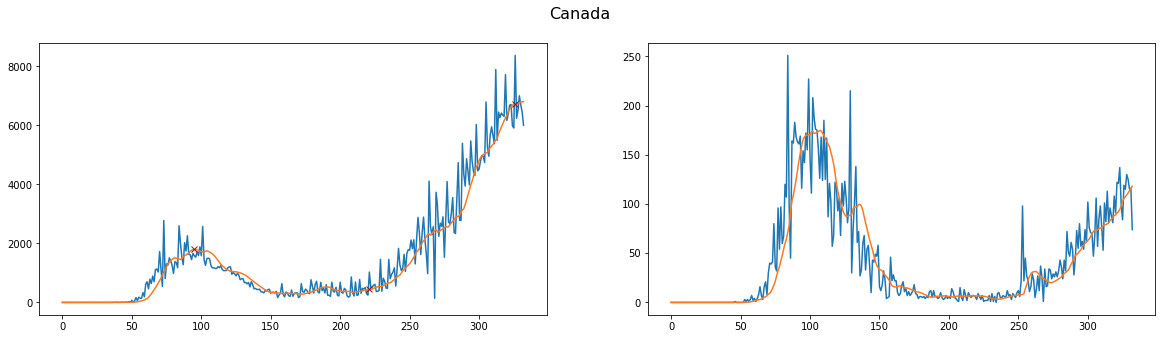

In [209]:
plot_lines(17)

In [71]:
rate = np.nan_to_num(smooth_deaths/smooth_cases)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


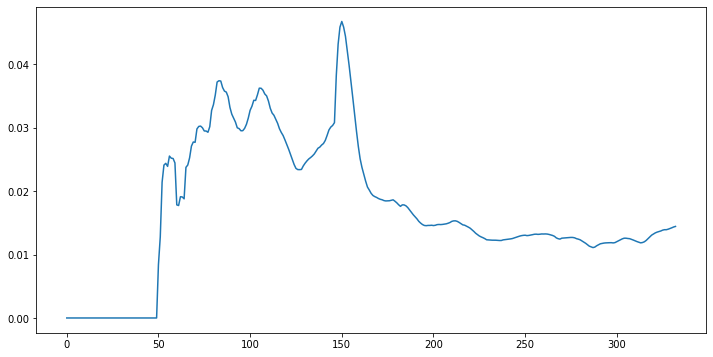

In [73]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(rate[36])

In [197]:
max([len(x) for x in peak_rates])

3

In [203]:
pad_rates = [np.pad(a, (0, max([len(x) for x in peak_rates]) - len(a)), 'constant', constant_values=(0, 0)) for a in peak_rates]
plot_rates = np.transpose(pad_rates)

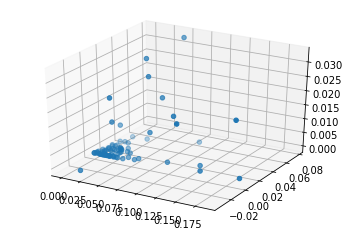

In [208]:
ax = plt.axes(projection='3d')
ax.scatter3D(plot_rates[0], plot_rates[1], plot_rates[2]);